In [1]:
### PSF_comparison.ipynb
### Author: Emily Ramey
### Compares Blake's PSF simulations from KAPA to Carlos's (both in H-band)

# Useful modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
# Image resizing/rescaling/downscaling
from skimage.transform import rescale, resize, downscale_local_mean
from PSF_analysis import gauss_fit, ee

In [2]:
### File and folder locations:
root_dir = "/g2/scratch/ao/kapa/psfs/"
blake_folder = root_dir+"maos/ltao_7_7_hy/"
carlos_folder = root_dir+"carlos/gc_sim/"
# Relevant FITS data
blake_center_file = blake_folder+"evlpsfcl_1_x0_y0.fits"
carlos_all_files = carlos_folder+"PSF2D_Hband_NyqSampl_LgsAstRadius7p6arcsec_ZA50_5000iter_4LGSsquare.fits" # my God

In [3]:
### Function(s)
def get_img(data, i=0, j=0):
    """
    Return image block at location i,j in Carlos's full FITS block
    Center coordinates are 0, 0
    i,j range from -5 to +5
    
    """
    # Shift indices to be positive
    i += 5
    j += 5
    
    # Get image at index
    s, L = data.shape # s = side of one img (px), L = total block length (px)
    S = int(np.sqrt(L/s)) # number of images on one side of square
    start_img = s*(S*i+j) # flat array index * px length of one image
    
    return data[:, start_img:start_img+s]

def ee50(psf, res):
    """
    Finds the radius which contains 50% of the encircled energy
    returns: ee50, in pixels
    """
    size = psf.shape[0]
    normalized =  psf / sum(psf) # normalizes the data in order to find ee50
    ee_prev = None
    # check each radius for encircled energy of 50%
    for radius in np.linspace(0, size, res):
        ee_r = ee(normalized, radius, size)
        if ee_r > 50:
            post_dist = abs(ee_r - 0.5) #find the energy that's closest to 0.5
            prev_dist = abs(ee_prev - 0.5)
            return ee_r if post_dist < prev_dist else ee_prev
        ee_prev = ee_r
    print("The function should never reach this point")

In [4]:
### Read in files and extract center images:
### Assuming all data in first HDU
# Blake's data
with fits.open(blake_center_file) as f:
    blake_ctr = f[0].data
    blake_hdr = f[0].header
    #print(blake_hdr)
print("Blake img shape:", blake_ctr.shape) # sanity check 1

# Carlos's data
with fits.open(carlos_all_files) as f:
    carlos_all = f[0].data
    carlos_hdr = f[0].header
    #print(carlos_hdr)

# Extract Carlos's center image
carlos_ctr = get_img(carlos_all).T # note: we're not sure which orientation this should be, so add .T to switch x/y
# another note: Based on the hexagonal structure in the center of both PSFs it looks like the .T orientation is best
print("Carlos img shape before:", carlos_ctr.shape) # sanity check 2

### Question: do these two images have the same field of view? If not, how much should I crop?
# update: we are assuming they have similar plate scales and cropping Carlos's image to the size of Blake's


#print('Integrated Flux:')
#print('    Blake: ', blake_ctr.sum())
#print('    Carlos: ', carlos_ctr.sum())

# Normalize Carlos's image intensity to Blake's
#blake_ctr = blake_ctr / (blake_ctr * 0.02 * 0.02).sum()
carlos_ctr = carlos_ctr * blake_ctr.sum() * (120**2) / (carlos_ctr.sum() * 100**2)
#blake_ctr = blake_ctr / blake_hdr['SUM']

print('Peak Flux:')
print('    Blake: ', blake_ctr.max())
print('    Carlos: ', carlos_ctr.max())

# Amount by which we have to crop Carlos's image
crop = int((carlos_ctr.shape[0]-blake_ctr.shape[0])/2.0)
#print(crop)

### Rescale Carlos's image to match Blake's
carlos_ctr = carlos_ctr[crop:-crop, crop:-crop]
print("Carlos img shape after:", carlos_ctr.shape) # sanity check 3

Blake img shape: (100, 100)
Carlos img shape before: (120, 120)
Peak Flux:
    Blake:  0.5070636067331891
    Carlos:  0.5202498116619855
Carlos img shape after: (100, 100)


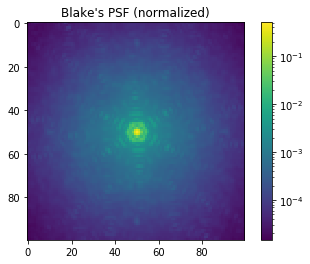

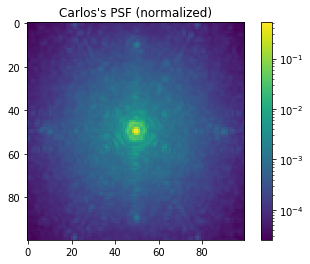

In [5]:
### Display normalized & cropped images for both PSFs

# Blake
plt.imshow(blake_ctr, norm=LogNorm())
plt.title("Blake's PSF (normalized)")
plt.colorbar()
plt.show()

# Carlos
plt.imshow(carlos_ctr, norm=LogNorm())
plt.title("Carlos's PSF (normalized)")
plt.colorbar()
plt.show()

In [6]:
### Get fwhm of each PSF # uses Blake's functions from analysis.py
fwhm_s = [] # x, y, and avg fwhm for both PSFs
ee_s = []

# Process each PSF
for PSF in [blake_ctr, carlos_ctr]:
    # fit a gaussian to each file
    gauss_params = gauss_fit(PSF)

    # record x, y, and avg FWHM
    FWHMx = 2 * np.sqrt(2*np.log(2)) * gauss_params[3] # converts sigma to FWHM
    FWHMy = 2 * np.sqrt(2*np.log(2)) * gauss_params[4]
    FWHMavg = (FWHMx + FWHMy) / 2 # in pixels
    fwhm_s.append([FWHMx, FWHMy, FWHMavg])
    
    # find ee50, the radius at which the encircled energy is at 50%
    ee_s.append(ee50(PSF, 1000))

In [7]:
### Compare the FWHM and enclosed energies of the two PSFs
fwhm_s = np.array(fwhm_s)
fwhm_diffs = np.abs(fwhm_s[0]-fwhm_s[1])
fwhm_err = fwhm_diffs/np.mean(fwhm_s, 0)*100
print("FWHMx error:", np.round(fwhm_diffs[0], 2), "px ;", np.round(fwhm_err[0], 2), 
      "%\nFWHMy error:", np.round(fwhm_diffs[1], 2), "px ;", np.round(fwhm_err[1], 2), 
      "%\nFWHM avg error:", np.round(fwhm_diffs[2], 2), "px ;", np.round(fwhm_err[2], 2), "%\n")

ee_diff = np.abs(ee_s[0]-ee_s[1])
ee_err = ee_diff/np.mean(ee_s)*100
print("Enclosed energy error:", np.round(ee_diff, 3), "pixels ;", np.round(ee_err, 3), "%")

FWHMx error: 0.08 px ; 3.55 %
FWHMy error: 0.04 px ; 1.85 %
FWHM avg error: 0.02 px ; 0.88 %

Enclosed energy error: 0.015 pixels ; 0.03 %


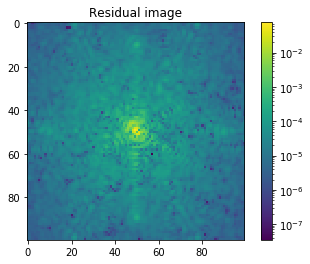

In [8]:
### Subtract the two images
resid = np.abs(blake_ctr-carlos_ctr)
resid = resid/np.sum(resid)
plt.imshow(resid, norm=LogNorm())
plt.title("Residual image")
plt.colorbar()
plt.show()